En el dia a dia, es comun trabajar con bases de datos incompletas. Por otra parte en Chile tenemos la suerte de contar con un Rol unico nacional que se encuenra asigna al momento de la inscripción en el registro civil, normalmente en una fecha proxima al nacimiento del individuo. Para el analisis se realizó una busqueda manual en Google, utilizando herramientas de busqueda avanzada para archivos .pdf y .xlsx que contuvieran tanto el Run, como fecha de nacimiento de ciudadanos chilenos.Se identificaron 2087 run con sus respectivas fechas de nacimiento. Los datos fueron importados y consolidados mediante Microsoft Excel e importados a R para su procesamiento. Dado que el Run corresponde a un dato identificatorio, no se disponibilizará la base de datos para este proyecto. 

### Procesamiento en R
Comenzamos importando las librerias a utilizar. 

In [1]:
library(tidyverse) #importamos el "pipeline", así como dplyr la que incorpora funciones como mutate() para la transformación de datos. 
library(lubridate) #Librería para la manipulacion de datos correspondientes a fechas. 
library(readxl)  #libreria para importar archivos desde Microsoft Excel y para la creación de archivos .xlsx
library(scales)  #libreria que usada en conjunto con ggplot, permite dar formato a los ejes de los graficos a generar.

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: timechange


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




In [2]:

data<-readxl::read_xlsx(path="/Datos/Datos_run.xlsx",sheet="Run")


#Tomamos unicamente las columnas Run y Fecha de nacimiento y realizamos el calculo de la edad
data<-data[c("Run","Fecha_nacimiento")] %>% 
  dplyr::mutate(Edad=trunc((Fecha_nacimiento %--% today()) / years(1)))
#Evaluamos la correlación entre el Run y ambas variables.
cor(x=data$Run, y=data$Edad) 
print("Se observa una relacion inversa con valor cercano a -1.")
cor(x=data$Run, y=year(data$Fecha_nacimiento))
print("Se observa una relacion directa y, como es esperable de magnitud similar a la edad, con valor cercano a 1.")

[1] -0.987358

[1] "Se observa una relacion inversa"


[1] 0.9873484

[1] "Se observa una relacion directa y, como es esperable de magnitud similar a la edad"


Graficamos ambas variables para apreciar mas claramente dicha relación. 

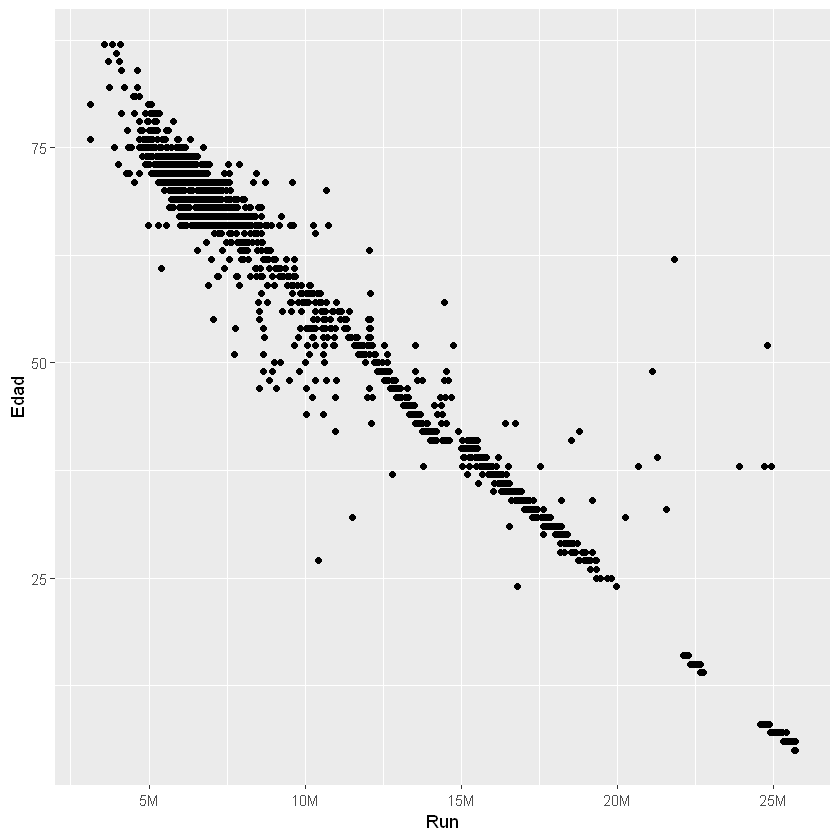

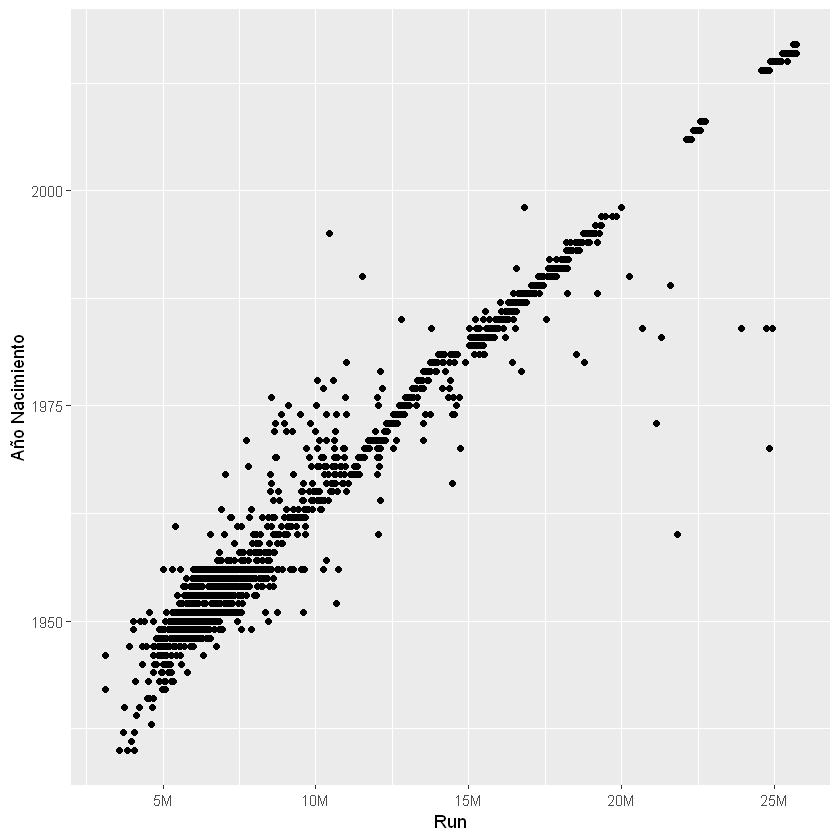

In [3]:
ggplot(data=data, aes(x=Run, y=Edad))+
    geom_point()+
   scale_x_continuous("Run",labels = scales::label_number(scale_cut = scales::cut_short_scale()))

ggplot(data=data, aes(x=Run, y=year(Fecha_nacimiento)))+
    geom_point()+
   scale_x_continuous("Run",labels = scales::label_number(scale_cut = scales::cut_short_scale()))+
    labs(y="Año Nacimiento")

Dada la distribución observada, planteamos un modelo de regresion lineal

In [4]:
modelo<-lm(Edad ~ Run, data=data)

summary(modelo)


Call:
lm(formula = Edad ~ Run, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.485  -1.183  -0.112   1.297  44.114 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.170e+01  1.216e-01   754.3   <2e-16 ***
Run         -3.376e-06  1.021e-08  -330.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.052 on 2817 degrees of freedom
Multiple R-squared:  0.9749,	Adjusted R-squared:  0.9749 
F-statistic: 1.093e+05 on 1 and 2817 DF,  p-value: < 2.2e-16


En base al resumen del modelo se establece la ecuación para la recta ajustada a la muestra como:
#### Edad = 9.170e+01 -3.376e-06 * Run

`geom_smooth()` using formula = 'y ~ x'


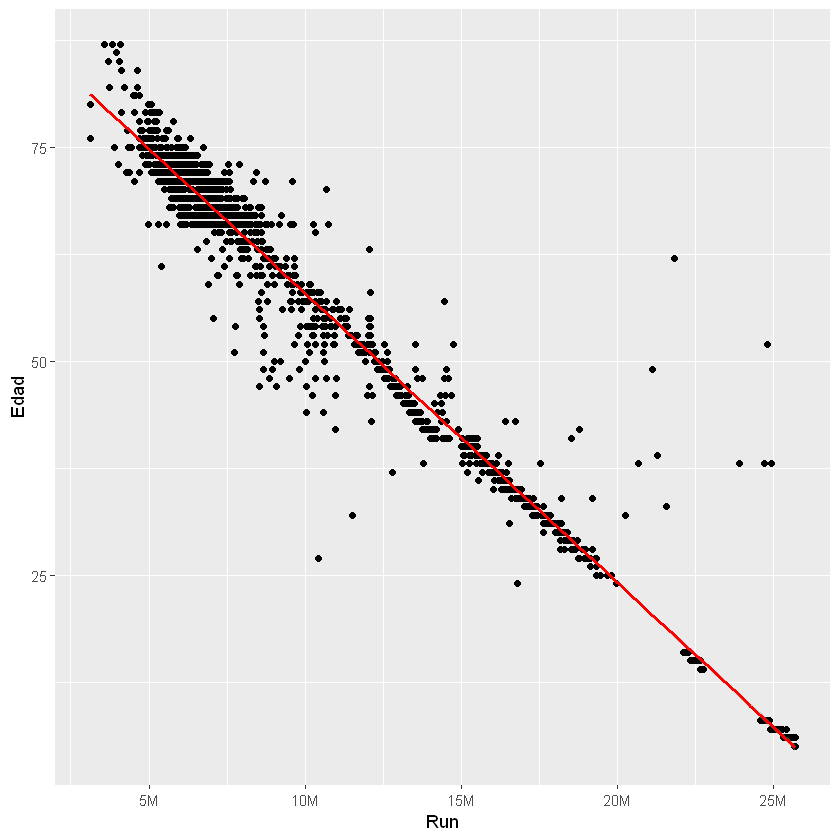

In [5]:
#Visualizamos la recta obtenida por la regresion lineal
ggplot(data=data, aes(x=Run, y=Edad))+
    geom_point()+
   scale_x_continuous("Run",labels = scales::label_number(scale_cut = scales::cut_short_scale()))+
    geom_smooth(method="lm", color="red")


Utilizaremos el modelo obtenido para predecir la edad de algunos Run.

In [10]:
predecir<-data.frame(Run=c(16093705,18907185, 17031040)) 
predecir<-predecir %>% 
  mutate(Year=trunc(predict(modelo, newdata = predecir)))

predecir

Run,Year
<dbl>,<dbl>
16093705,37
18907185,27
17031040,34


Finalmente graficamos los puntos predichos.

`geom_smooth()` using formula = 'y ~ x'


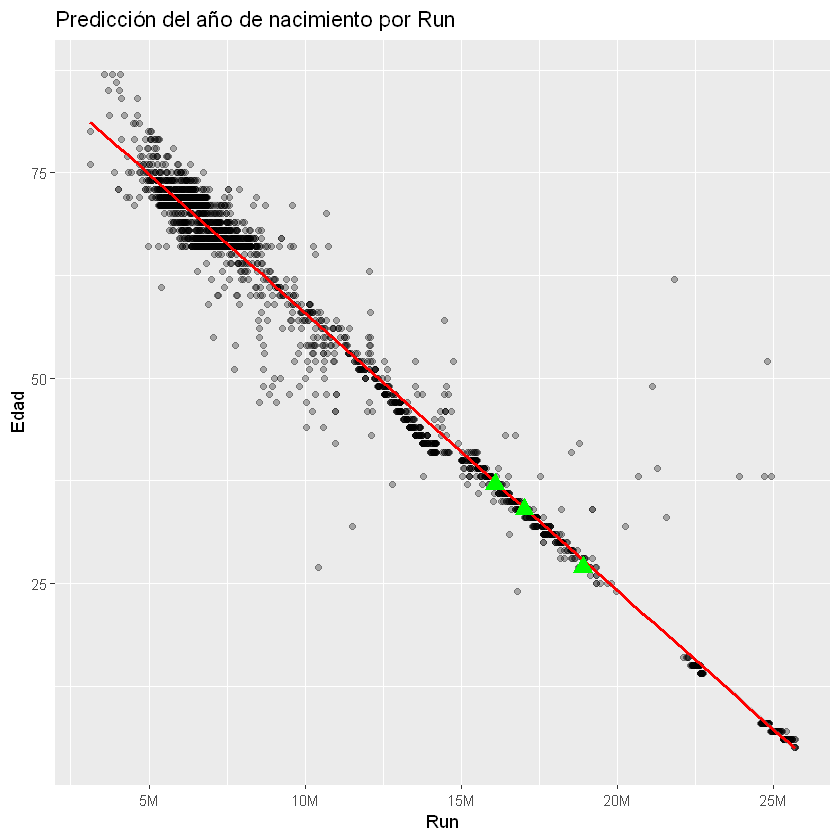

In [27]:
ggplot(data=data,aes(x=Run, y=Edad))+
  scale_x_continuous("Run",labels = scales::label_number(scale_cut = scales::cut_short_scale()))+
geom_point(alpha=0.3)+
geom_smooth(method="lm", color="red")+
  labs(title="Predicción del año de nacimiento por Run", 
       x="Run", 
       y="Edad"
       )+
geom_point(data=predecir,aes(Run, Year), color="green", size=4, shape=17)

Por tanto podemos concluir que podremos inferir la edad en ciudadanos Chilenos en base a su run aplicando la formula anteriormente descrita:
#### Edad = 9.170e+01 -3.376e-06 * Run